In [1]:
import os
import json
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle

import warnings
warnings.filterwarnings('ignore')

import lgdo.lh5_store as lh5

from multihist import Hist1d, Histdd
from datetime import datetime, timezone
from legendmeta import LegendMetadata

import pulser_analysis as pa

%load_ext autoreload
%autoreload 2

In [ ]:
"""period, run = 'p06', 'r007'
test_file = f'l200-{period}/{run}/l200-{period}-{run}-pulser-dict.txt'
test_dict_file = f'l200-{period}/{run}/l200-{period}-{run}-pulser-dict.json'
with open(test_file,'r') as datafile:
    n_test = int(len(datafile.read().split())/4)
test_dict = {}
for i in range(n_test):
    with open(test_file,'r') as datafile:
        temp = datafile.read().split()[i*4:(i+1)*4]
    cc4, ampl, att, key = temp
    ampl = float(ampl)
    att = int(att)
    key = f'20230726T{key}'
    if cc4 in test_dict:
        test_dict[cc4]['amplitudes'].append(ampl)
        test_dict[cc4]['attenuations'].append(att)
        test_dict[cc4]['keys'].append(key)
    else:
        test_dict[cc4] = {}
        test_dict[cc4]['amplitudes'] = [ampl]
        test_dict[cc4]['attenuations'] = [att]
        test_dict[cc4]['keys'] = [key]
with open(test_dict_file,'w') as f:
    json.dump(test_dict, f, indent=4)"""

In [3]:
period, run = 'p06', 'r007'
version = 'tmp/auto'
meta_path = f'/lfs/l1/legend/data/public/prodenv/prod-blind/{version}/inputs'
lmeta = LegendMetadata(path=meta_path)
chmap = lmeta.hardware.configuration.channelmaps.on("20230311T235840Z")
ge_all = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds']
ge_off = ['V07298B', 'P00665A', 'V01386A', 'V01403A', 'V01404A', 'B00091D', 'P00537A',
          'B00091B', 'P00538B', 'P00661A', 'P00665B', 'P00698B']
ge_keys = [ch for ch in ge_all if ch not in ge_off]
ge_rawid = [chmap[ch]['daq']['rawid']  for ch in ge_keys]
ge_table = [f'ch{rawid}' for rawid in ge_rawid]

raw_dir = f'/lfs/l1/legend/users/dandrea/test_data/raw/tst/{period}-{run}'
key_list = open(f'l200-{period}/{run}/l200-{period}-{run}-tst-key.list', "r")
key_list = key_list.read().split('\n')
raw_list = [f'{raw_dir}//l200-{period}-{run}-tst-{key}-tier_raw.lh5' for key in key_list]

test_dict_file = f'l200-{period}/{run}/l200-{period}-{run}-pulser-dict.json'
with open(test_dict_file,'r') as file:
    test_dict = json.load(file)

ch1104000 n. pulser events 5352 size 8192


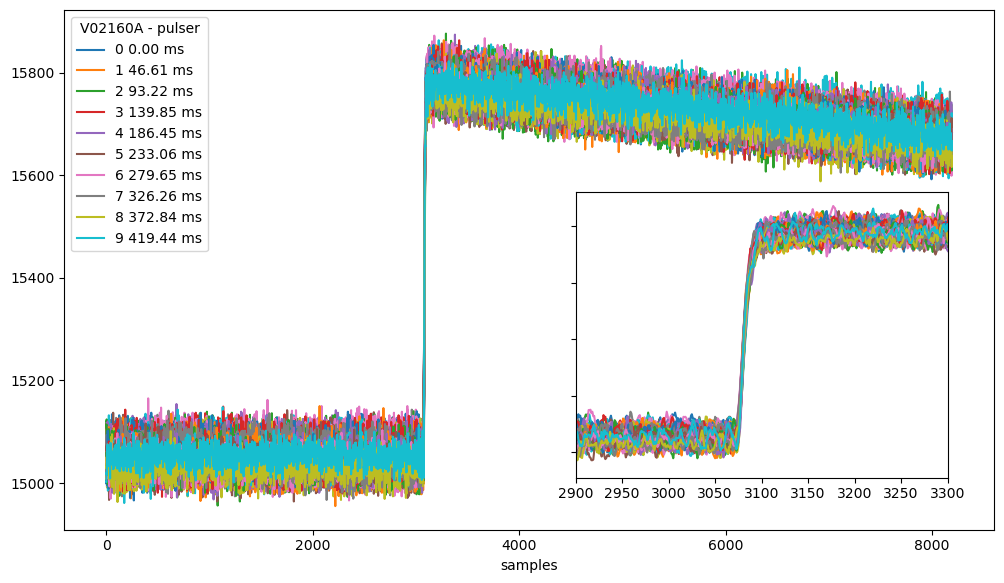

In [4]:
pa.plot_pulser_waveforms(ge_keys[0], 'pulser', raw_list[:1], nwf=100, xlim=(2900,3300))

[0.00627972 0.03147314 0.06279716 0.12529681 0.17698645 0.25
 0.31473135 0.35313439]
Pulser processing for V02160A String 1 CC4 C3
20230726T101651Z n. pulser events 5352 size 8192
Time to produce DSP data 13.3 s
20230726T102245Z n. pulser events 5351 size 8192
Time to produce DSP data 13.3 s
20230726T102828Z n. pulser events 5352 size 8192
Time to produce DSP data 13.8 s
20230726T103316Z n. pulser events 5353 size 8192
Time to produce DSP data 13.3 s
20230726T104032Z n. pulser events 5352 size 8192
Time to produce DSP data 13.8 s
20230726T104510Z n. pulser events 5351 size 8192
Time to produce DSP data 13.9 s
20230726T104959Z n. pulser events 5352 size 8192
Time to produce DSP data 13.3 s
20230726T105428Z n. pulser events 5352 size 8192
Time to produce DSP data 13.9 s


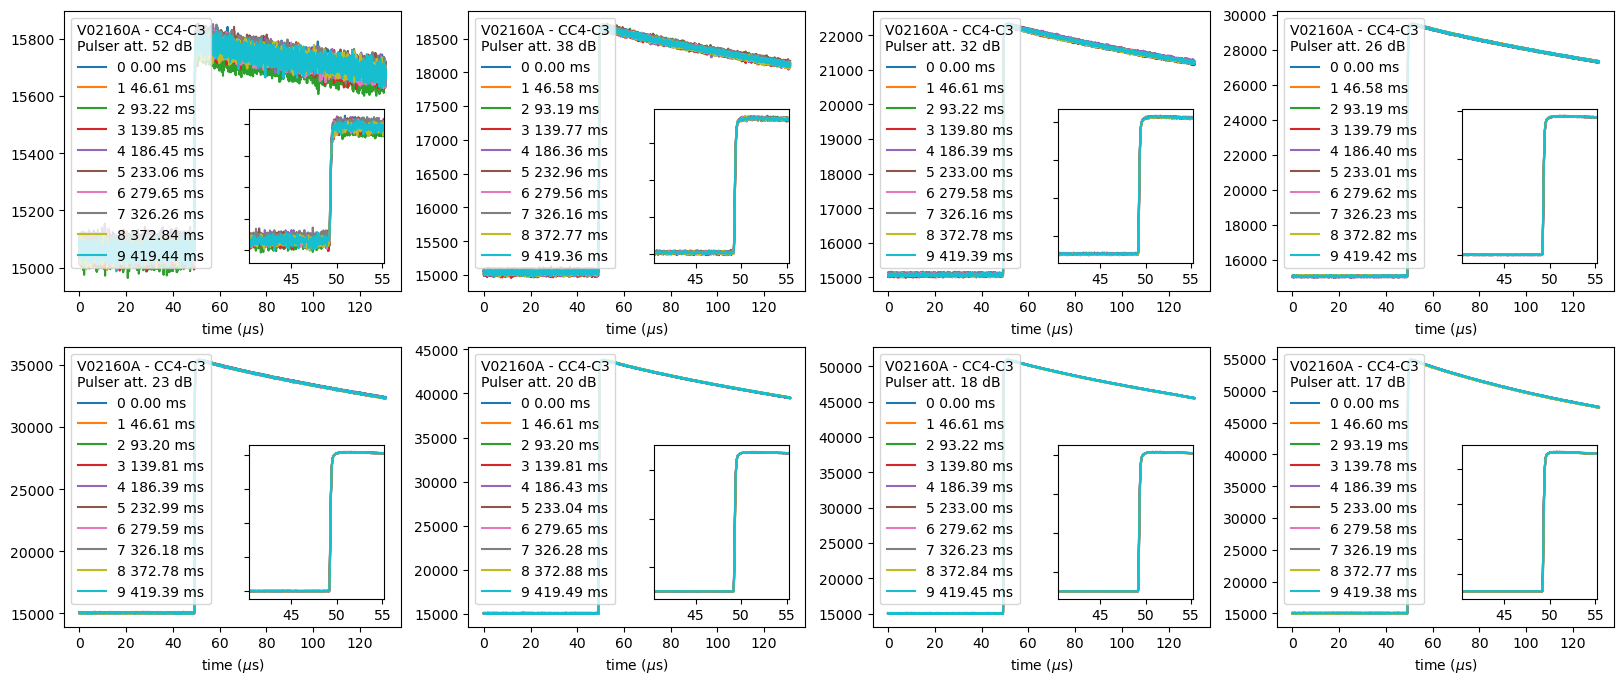

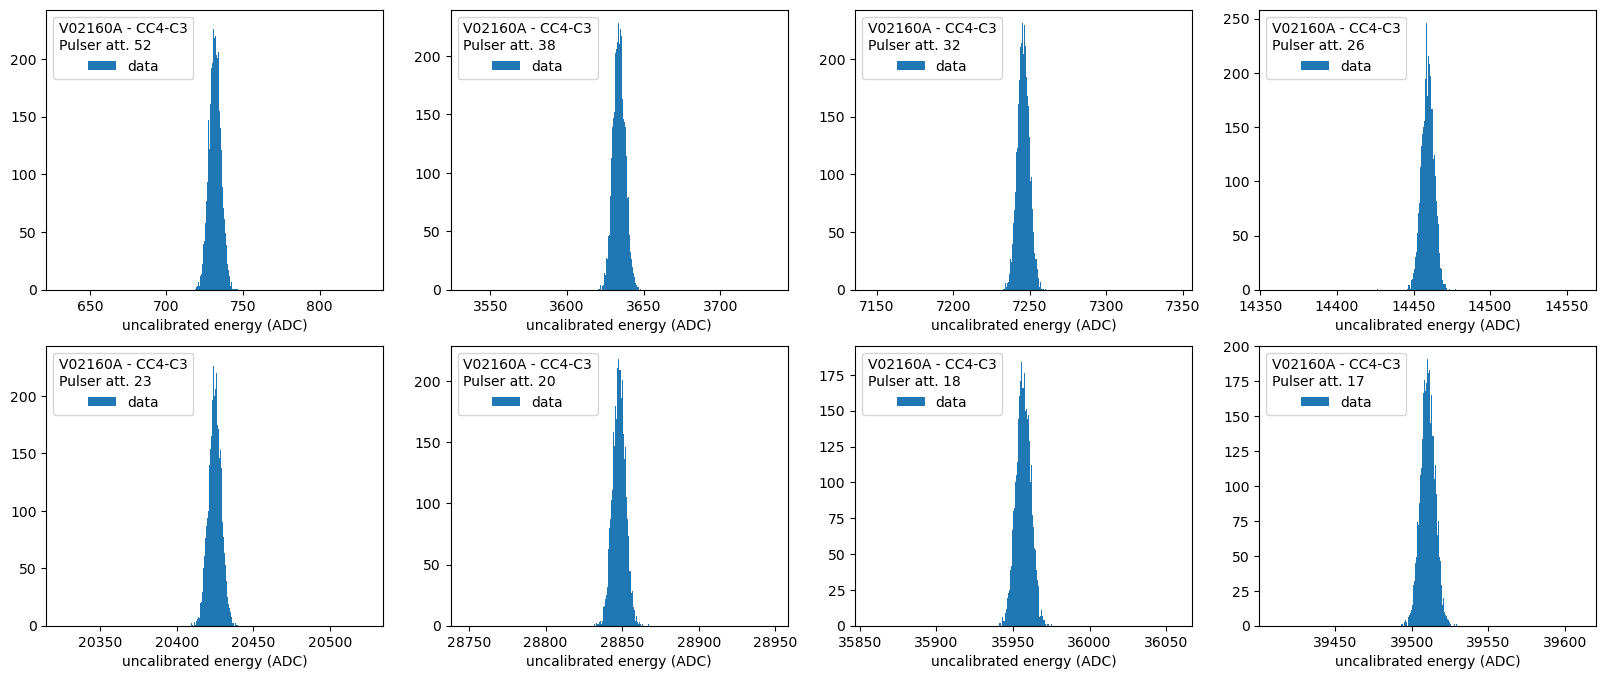

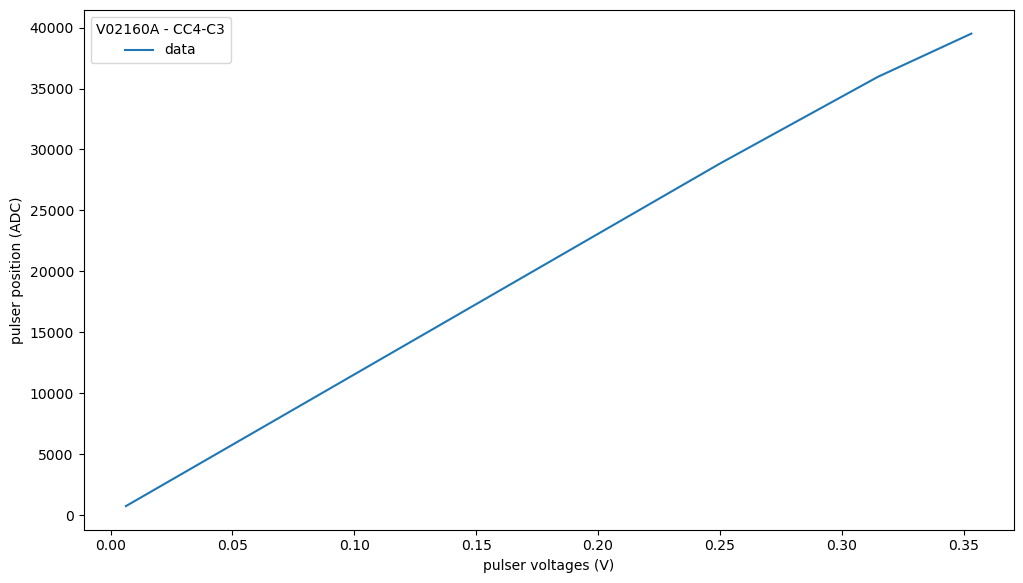

In [43]:
pa.pulser_processing('p06','r007',ge_keys[0], test_dict_file, raw_dir)

In [ ]:
pa.pulser_dsp_analysis(run, chmap, test_dict_file, n_test=2,n_acq=i, nstring=None,
                       plot_dir='r017/pulser_test/plots')

In [ ]:
def plot_pulser_info(chmap, test_dict, n_test, nstring = None, plot_dir = None):
    with open(test_dict_file,'r') as file:
        test_dict = json.load(file)
    acquistions = [k for k in test_dict[f'test{n_test}'].keys()][:]
    print(acquistions)
    fig0, axis0 = plt.subplots(nrows=4, ncols=3,figsize=(24,16), facecolor='white')
    fig1, axis1 = plt.subplots(nrows=4, ncols=3,figsize=(24,16), facecolor='white')
    ge_off = (26,33,46,47,48,50,84,85,94,105,112,116,117,120,122)
    strings = np.array([int(chmap[ch]['location']['string']) for ch in chmap.keys() if chmap[ch]['system']=='geds'])
    if nstring is None: nstring = strings.max()
    for string in range(1,nstring+1):
        ax0 = axis0.flat[string-1]
        ax1 = axis1.flat[string-1]
        #if n_test == 2: axin = ax1.inset_axes([0.24, 0.53, 0.35, 0.45])
        det_names = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds' and chmap[ch]['location']['string']==string]
        ge_numbers = [chmap[ch]['daq']['fcid'] for ch in det_names]
        cc4s = [chmap[ch]['electronics']['cc4']['id'] for ch in det_names]
        chns = [f'ch{n:03}' for n in ge_numbers if n not in ge_off ]
        det_names = [ch for n, ch in zip(ge_numbers,det_names) if n not in ge_off ]
        rate = [float(test_dict[f'test{n_test}'][f'{n_acq}']['rate']) for n_acq in acquistions]
        energy = [float(test_dict[f'test{n_test}'][f'{n_acq}']['energy'])*1000 for n_acq in acquistions]
        for i, chn in enumerate(chns[:]):
            if det_names[i] == 'B00089D': continue
            #try:
            fwhm = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['fwhm'] for n_acq in acquistions]
            fwhm_err = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['fwhm_err'] for n_acq in acquistions]
            pos = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['position'] for n_acq in acquistions]
            if n_test == 1:
                ax0.errorbar(rate, fwhm,yerr=fwhm_err,marker='o', label=f'{det_names[i]}-{cc4s[i]}')
                ax1.plot(rate, pos,'o-',label=f'{det_names[i]}-{cc4s[i]}')
            if n_test == 2:
                ax0.errorbar(energy, fwhm,yerr=fwhm_err,marker='o', label=f'{det_names[i]}-{cc4s[i]}')
                ax1.plot(energy, pos,'o-',label=f'{det_names[i]}-{cc4s[i]}')
                #axin.plot(energy, pos,'o-',label=f'{det_names[i]}')
            #except: pass
        ax0.legend(title=f'String {string}',loc='upper left')
        if n_test == 1:
            ax0.set_xscale('log')
            ax1.set_xscale('log')
            x_name = 'rate (Hz)'
            fstring = 'rate'
            xlims = (0.005,120)
        if n_test == 2:
            x_name = 'expected position (keV)'
            fstring = 'position'
            xlims = (-2000,6100)
        ax0.set_xlabel(x_name)
        ax0.set_ylabel('FWHM (keV)')
        ax0.set_xlim(xlims[0],xlims[1])
        ax1.legend(title=f'String {string}',loc='upper left')
        ax1.set_xlabel(x_name)
        ax1.set_ylabel('pulser position (keV)')
        ax1.set_xlim(xlims[0],xlims[1])
        """if n_test == 2:
            axin.set_xlim(40,250)
            axin.set_ylim(40,500)
            axin.set_yticklabels('')"""
    if plot_dir is not None:
        fig0.savefig(f'{plot_dir}/test{n_test}_fwhm_vs_{fstring}.png',dpi=300, bbox_inches='tight')
        fig1.savefig(f'{plot_dir}/test{n_test}_position_vs_{fstring}.png',dpi=300, bbox_inches='tight')

In [ ]:
plot_pulser_info(chmap, test_dict, n_test=1, nstring = None, plot_dir = 'r017/pulser_test/plots')

In [ ]:
plot_pulser_info(chmap, test_dict, n_test=2, nstring = None, plot_dir = 'r017/pulser_test/plots')